In [1]:
#Below is the code to generate different randomized compiling versions of the BCS Trotter circuit


from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, transpile, assemble
import numpy as np
from functions_randomized_compiling import *

#Which Trotter circuit do you want to randomized compiling
initial_step=15 # initial Trotter step 
final_step=15 #final Trotter step
#measurement='ZZZ' 
measurement='XYZ'
nb_twirls=30 #number of twirl

backend ='ibm_lagos'
coupling_map=[[0, 1],[1, 0],[1, 2],[1, 3],[2, 1],[3, 1],[3, 5],[4, 5],[5, 3],[5, 4],[5, 6],[6, 5]]#coupling_map of 'ibm_lagos'
   

In [2]:
#Standard Randomized compiling, Pauli twirling on control and target qubits of the CNOT
dt=0.2 #Trotter time step
g=0.5 #coupling constant

qc_tw_std=list(list([] for _ in range(nb_twirls)) for _ in range(final_step-initial_step+1))
for t in range(initial_step,final_step+1):
    T=dt*t
    #upload the BCS Trotter_circuit
    qc=QuantumCircuit.from_qasm_file('data/'+measurement+'/T='+str(round(T,1))+'/trotter_g='+str(g)+'_dt='+str(round(dt,3))+'_backend='+str(backend)+'.qasm')
    for k in range(nb_twirls):
        qc_tw_std[t-initial_step][k]=standard_twirl(qc) #generate a list of standard randomized compiling circuits

300 standard randomized compiling circuits from initial_step=1 to final_step=15 are available in QASM format for both measurements (XYZ/ZZZ) in the folder data, the corresponding folder measurement and at their corresponding time step folder in 'randomized_compiling/Quantum_Circuit/trotter_standard_twirl_g=0.5=dt=0.2_backend_ibm_lagos_"twirl number".qasm'

In [3]:
#crosstalk twirling, Pauli twirling on control and target qubits of the CNOT 
#and pauli + Pi/2 rotation on neighbouring qubits

dt=0.2 #Trotter time step
g=0.5 #coupling constant

qc_tw_ct=list(list([] for _ in range(nb_twirls)) for _ in range(final_step-initial_step+1))
for t in range(initial_step,final_step+1):
    T=dt*t
    #upload the BCS Trotter_circuit
    qc=QuantumCircuit.from_qasm_file('data/'+measurement+'/T='+str(round(T,1))+'/trotter_g='+str(g)+'_dt='+str(round(dt,3))+'_backend='+str(backend)+'.qasm')
    for k in range(nb_twirls):
        qc_tw_ct[t-initial_step][k]=crosstalk_twirl(qc,coupling_map) #cross-talk twirling randomized compiling

300 crosstalk randomized compiling circuits from initial_step=1 to final_step=15 are available in QASM format for both measurements (XYZ/ZZZ) in 'data/"measurement(XYZ/ZZZ)"/t="time step"/randomized_compiling/Quantum_Circuit/trotter_crosstalk_twirl_g=0.5=dt=0.2_backend_ibm_lagos_"twirl number".qasm'

In [4]:
#Simulation of the generated circuits to check they are equivalent without any noisy gates, 
#differences are only due to shot noise

#qc_list=qc_tw_u #simulation for the usual randomized compiling circuit
qc_list=qc_tw_ct #simulation for the randomized compiling circuit with cross-talk twirling

#Simulation of the randomized compiling circuit on a perfect QC

nb_shots=32000 #number of shots
sim = Aer.get_backend('aer_simulator')
counts=list(list({} for _ in range(nb_twirls)) for _ in range(final_step-initial_step+1))
for t in range(initial_step,final_step+1):
    for i in range(nb_twirls):
        qobj = assemble(qc_list[t-initial_step][i])
        counts[t-initial_step][i]= sim.run(qobj,shots=nb_shots).result().get_counts()


In [5]:
#Computing the 7 different observables from the perfect simulation

#convert the dictionnary counts in an array
data_counts=list(list(np.zeros(8) for _ in range(nb_twirls)) for _ in range(final_step-initial_step+1))
for t in range(initial_step,final_step+1):
    for i in range(nb_twirls):
        for bit_0 in range(2):
            for bit_1 in range(2):
                for bit_2 in range(2):
                    ind=bit_0*4+bit_1*2+bit_2
                    bit_string=str(bit_0)+str(bit_1)+str(bit_2)
                    if bit_string in counts[t-initial_step][i]:
                        data_counts[t-initial_step][i][ind]=counts[t-initial_step][i][bit_string]/nb_shots

#list of the different observables one can have access, numbers correspond to the measured qubits                  
meas_list=[[0],[1],[2],[0,1],[0,2],[1,2],[0,1,2]]

sim_obs=list(list(list( 0. for _ in range(nb_twirls)) for _ in range(final_step-initial_step+1)) for _ in range(7))

for t in range(initial_step,final_step+1):
    if t//2*2!=t:
        lay=[0,2,1]
    else:
        lay=[0,1,2]#take into account the final layout at different time due to SWAP gate
    for obs in range(len(meas_list)):
        m=list(lay[meas] for meas in meas_list[obs])
        for p in range(nb_twirls):
            sim_obs[obs][t-initial_step][p]=sum((-1)**(sum(k//2**m[i] for i in range(len(m))))*data_counts[t-initial_step][p][k]  for k in range(8))



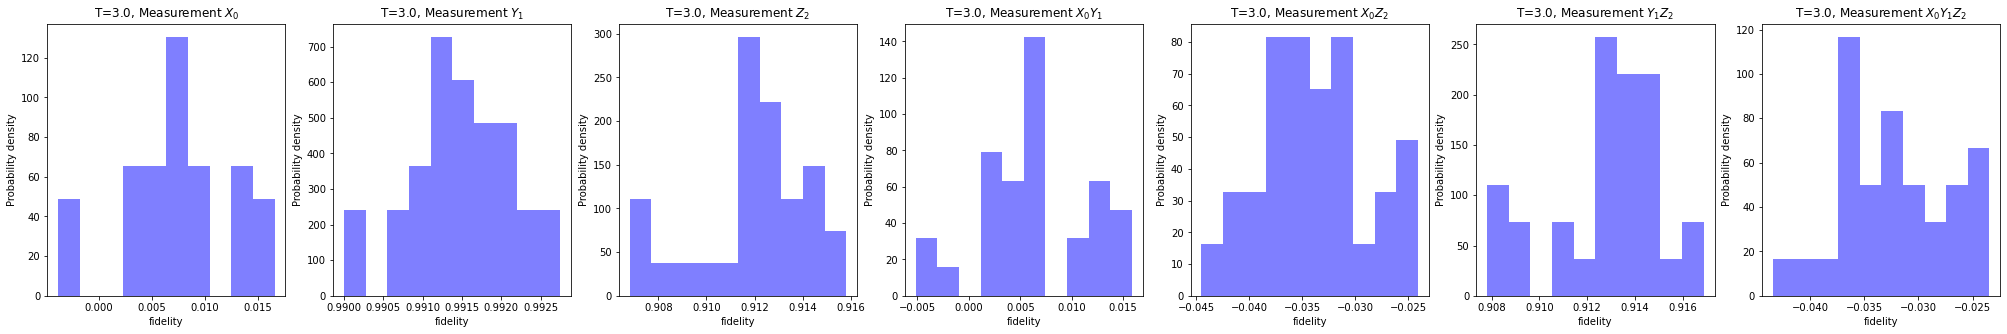

In [6]:
import matplotlib.pyplot as plt
if measurement=='ZZZ':
    title=['$Z_0$', '$Z_1$','$Z_2$','$Z_0 Z_1$','$Z_0 Z_2$','$Z_1 Z_2$','$Z_0 Z_1 Z_2$']
    
if measurement=='XYZ':
    title=['$X_0$', '$Y_1$','$Z_2$','$X_0 Y_1$','$X_0 Z_2$','$Y_1 Z_2$','$X_0 Y_1 Z_2$']
    
for t in range(initial_step,final_step+1):
    fig, axs = plt.subplots(1, 7,figsize=(35,5))
    for o in range(7):
        axs[o].hist(sim_obs[o][t-initial_step], density=True,color='b',alpha=0.5);
        axs[o].set_title('T='+str(round(t*dt,1))+', Measurement '+title[o])
        for ax in axs.flat:
            ax.set(xlabel='fidelity', ylabel='Probability density')
        